In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
import scipy.signal as signal


In [2]:
# quant iir
class QuantizedIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2, iir_coeff_bit, output_dec_bits=1):
        # 系数量化
        coeff_quant_factor = 1/(2**iir_coeff_bit)
        self.b0 = np.round(b0 / coeff_quant_factor) * coeff_quant_factor
        self.b1 = np.round(b1 / coeff_quant_factor) * coeff_quant_factor
        self.b2 = np.round(b2 / coeff_quant_factor) * coeff_quant_factor
        self.a1 = np.round(a1 / coeff_quant_factor) * coeff_quant_factor
        self.a2 = np.round(a2 / coeff_quant_factor) * coeff_quant_factor

        # floor is just for debug, not used in real quantization
        # self.b0 = np.floor(b0 / coeff_quant_factor) * coeff_quant_factor
        # self.b1 = np.floor(b1 / coeff_quant_factor) * coeff_quant_factor
        # self.b2 = np.floor(b2 / coeff_quant_factor) * coeff_quant_factor
        # self.a1 = np.floor(a1 / coeff_quant_factor) * coeff_quant_factor
        # self.a2 = np.floor(a2 / coeff_quant_factor) * coeff_quant_factor
        

        # 初始化存储过去的值, y1 y2为高bit的值
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
        
        # 系数量化银子
        self.coeff_quant_factor = coeff_quant_factor
        # 输出量化因子
        self.output_dec_bits = output_dec_bits
        self.output_quant_factor = 0.5**output_dec_bits
    
    def process(self, x):
        # 计算当前输出
        y1_q = self.y1 / self.output_quant_factor
        y2_q = self.y2 / self.output_quant_factor
        a1_q = self.a1 / self.coeff_quant_factor
        a2_q = self.a2 / self.coeff_quant_factor

        # feed back: a1y1 + a2y2, # + 2**(self.output_dec_bits-1)
        feed_back_requant = np.floor((a1_q * y1_q + a2_q * y2_q) * self.output_quant_factor) * self.coeff_quant_factor
        y = self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - feed_back_requant
        y = np.floor(y / self.output_quant_factor) * self.output_quant_factor

        
        # 更新历史值
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

In [3]:
# float iir
class FloatIIRFilter:
    def __init__(self, b0, b1, b2, a1, a2):
        self.b0 = b0
        self.b1 = b1
        self.b2 = b2
        self.a1 = a1
        self.a2 = a2
        # 初始化存储过去的值, y1 y2为高bit的值
        self.x1 = 0
        self.x2 = 0
        self.y1 = 0
        self.y2 = 0
    
    def process(self, x):
        # 计算当前输出
        y = (self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - 
             self.a1 * self.y1 - self.a2 * self.y2)

        # 更新历史值
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

In [4]:

fs = 10000  # 每秒采样点数
time = 100  # 仿真时间
num_samples = fs * time  # 总样本数
t = np.linspace(0, time, num_samples, endpoint=False)
signal_range = 1000

# 生成一个从1Hz到2500Hz的正弦波信号，1s一个频率段
start_freq = 1      # 起始频率
end_freq = 2500     # 终止频率
generated_signal = np.zeros_like(t)
for i in range(time):
    freq = start_freq + i * (end_freq - start_freq) / time
    t_segment = t[i * fs : (i + 1) * fs]
    sine_segment = np.sin(2 * np.pi * freq * t_segment)
    generated_signal[i * fs : (i + 1) * fs] = np.round(sine_segment * signal_range)
# plt.plot(t, generated_signal, label='Generated Signal')


In [5]:
# 计算低通滤波器系数（fc/fs = 0.1）
fc_fs_ratio = 0.11
fc = fc_fs_ratio * fs  # 截止频率（Nyquist频率的一半）
# 使用scipy设计一个2阶低通Butterworth滤波器
b, a = butter(2, fc / (fs/2), btype='low')
b, a

(array([0.07909372, 0.15818744, 0.07909372]),
 array([ 1.        , -1.06224443,  0.3786193 ]))

revise gain v2: 3.1608072796656175
coeff_quant_error_forward: 0.0
coeff_quant_error_total: 0.0
feedbackY_quant_error_forward: 0.0625
feedbackY_quant_error_total: 0.1975504549791011


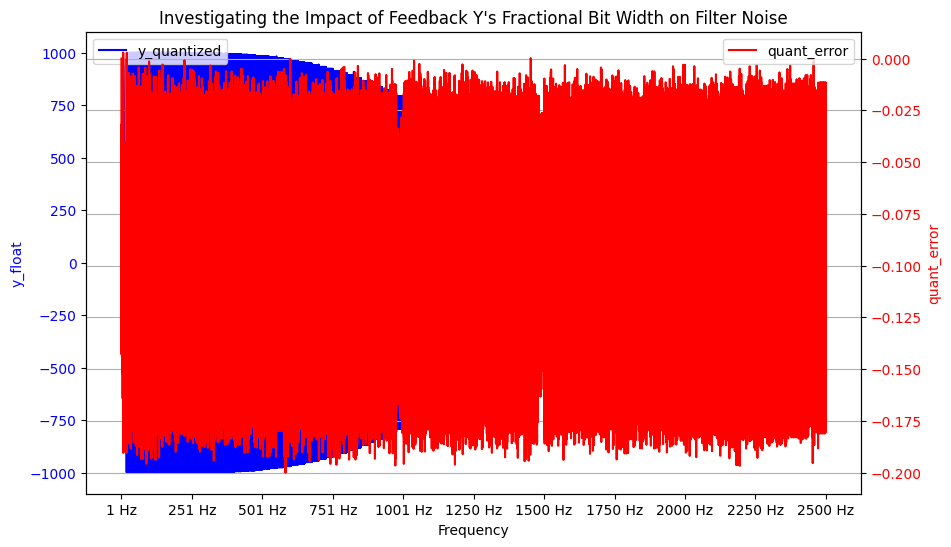

In [6]:
# 探究反馈Y的小数位宽对滤波器性能的影响
iir_coeff_bit = 31
output_dec_bits= 4
quant_iir = QuantizedIIRFilter(b[0], b[1], b[2], a[1], a[2], iir_coeff_bit, output_dec_bits)
float_iir = FloatIIRFilter(b[0], b[1], b[2], a[1], a[2])
y_quantized = np.array([quant_iir.process(x) for x in generated_signal])
y_float = np.array([float_iir.process(x) for x in generated_signal])

# 详细绘制量化误差
fig, ax1 = plt.subplots(figsize=(10, 6))

# 左侧纵轴：绘制 y_float
ax1.plot(t, y_quantized, label="y_quantized", color='b')
freq_ticks = [start_freq + i * (end_freq - start_freq) / time for i in range(0, time+1, 10)]
time_ticks = [i for i in range(0, time+1, 10)]
ax1.set_xticks(time_ticks)
ax1.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks])
ax1.set_xlabel('Frequency')
# ax1.set_xlabel('Time [s]')
ax1.set_ylabel('y_float', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 右侧纵轴：绘制量化误差
ax2 = ax1.twinx()  # 创建第二个y轴
ax2.plot(t, y_quantized-y_float, label="quant_error", color='r')
ax2.set_ylabel('quant_error', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# 添加图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 设置标题和显示网格
plt.title("Investigating the Impact of Feedback Y's Fractional Bit Width on Filter Noise")
plt.grid(True)

delta_error_list = []
delta_error_list.append((quant_iir.b0 - b[0])*signal_range)
delta_error_list.append((quant_iir.b1 - b[1])*signal_range)
delta_error_list.append((quant_iir.b2 - b[2])*signal_range)
delta_error_list.append(-(quant_iir.a1 - a[1])*signal_range)
delta_error_list.append(-(quant_iir.a2 - a[2])*signal_range)
quant_err_total = sum(delta_error_list)

# feedback quantization error is actually forward_quantization_error/(1-r), r is magnitude of the pole
coeff_quant_error_forward = quant_err_total
feedbackY_quant_error_forward = 2**(-output_dec_bits)

z, p, k = signal.tf2zpk(b, a)
print(f"revise gain v2: {1 / sum(a)}")
print(f"coeff_quant_error_forward: {coeff_quant_error_forward}")
print(f"coeff_quant_error_total: {coeff_quant_error_forward * (1 / sum(a))}")
print(f"feedbackY_quant_error_forward: {feedbackY_quant_error_forward}")
print(f"feedbackY_quant_error_total: {feedbackY_quant_error_forward * (1 / sum(a))}")


revise gain v2: 3.1608072796656175
coeff_quant_error_forward: 0.06103515625
coeff_quant_error_total: 0.1929203661905284
feedbackY_quant_error_forward: 2.3283064365386963e-10
feedbackY_quant_error_total: 7.359327933903824e-10


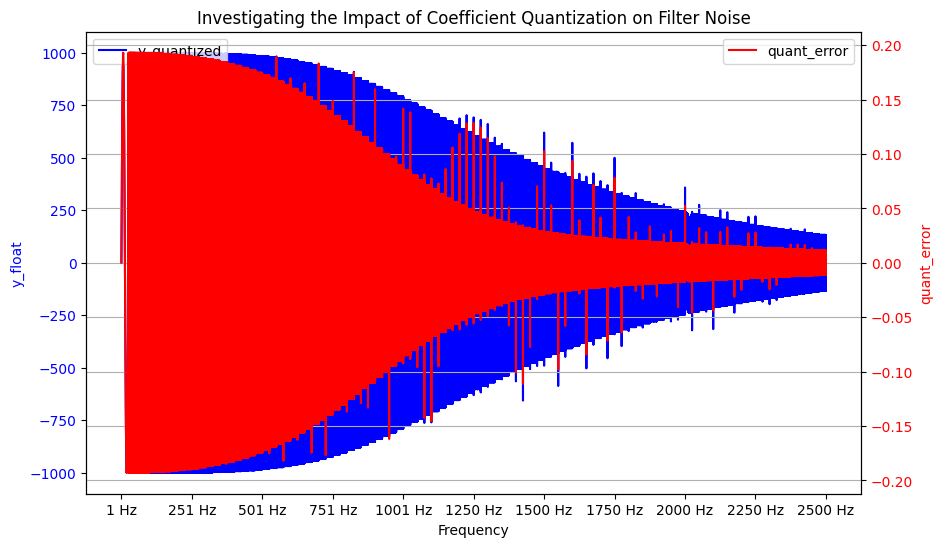

In [9]:
# 探究系数量化对滤波器性能的影响
iir_coeff_bit = 14
output_dec_bits= 32
quant_iir = QuantizedIIRFilter(b[0], b[1], b[2], a[1], a[2], iir_coeff_bit, output_dec_bits)
float_iir = FloatIIRFilter(b[0], b[1], b[2], a[1], a[2])
y_quantized = np.array([quant_iir.process(x) for x in generated_signal])
y_float = np.array([float_iir.process(x) for x in generated_signal])

# 详细绘制量化误差
fig, ax1 = plt.subplots(figsize=(10, 6))

# 左侧纵轴：绘制 y_float
ax1.plot(t, y_quantized, label="y_quantized", color='b')
# ax1.set_xlabel('Time [s]')
freq_ticks = [start_freq + i * (end_freq - start_freq) / time for i in range(0, time+1, 10)]
time_ticks = [i for i in range(0, time+1, 10)]
ax1.set_xticks(time_ticks)
ax1.set_xticklabels([f'{f:.0f} Hz' for f in freq_ticks])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('y_float', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 右侧纵轴：绘制量化误差
ax2 = ax1.twinx()  # 创建第二个y轴
ax2.plot(t, y_quantized-y_float, label="quant_error", color='r')
ax2.set_ylabel('quant_error', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# 添加图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 设置标题和显示网格
plt.title("Investigating the Impact of Coefficient Quantization on Filter Noise")
plt.grid(True)

delta_error_list = []
delta_error_list.append((quant_iir.b0 - b[0])*signal_range)
delta_error_list.append((quant_iir.b1 - b[1])*signal_range)
delta_error_list.append((quant_iir.b2 - b[2])*signal_range)
delta_error_list.append(-(quant_iir.a1 - a[1])*signal_range)
delta_error_list.append(-(quant_iir.a2 - a[2])*signal_range)
quant_err_total = sum(delta_error_list)

# feedback quantization error is actually forward_quantization_error/(1-r), r is magnitude of the pole
coeff_quant_error_forward = quant_err_total
feedbackY_quant_error_forward = 2**(-output_dec_bits)

z, p, k = signal.tf2zpk(b, a)
print(f"revise gain v2: {1 / sum(a)}")
print(f"coeff_quant_error_forward: {coeff_quant_error_forward}")
print(f"coeff_quant_error_total: {coeff_quant_error_forward * (1 / sum(a))}")
print(f"feedbackY_quant_error_forward: {feedbackY_quant_error_forward}")
print(f"feedbackY_quant_error_total: {feedbackY_quant_error_forward * (1 / sum(a))}")

In [8]:
# 谐振点测试
poles = np.roots(a)
resonant_poles = [p for p in poles if np.imag(p) != 0]
pole_angle = np.angle(resonant_poles[0])   # 取一个即可（共轭角度相同）
w_res = abs(pole_angle)
f_res = w_res / (np.pi) * fs / 2  # 转换为频率
print(f"resonant frequency: {f_res} Hz")
r_decay = np.abs(resonant_poles[0])  # 极点的模
Q = 1 / (2 * (1 - np.abs(resonant_poles[0])))  # Q值计算
print(f"Q factor: {Q}")

resonant frequency: 842.3982370885038 Hz
Q factor: 1.2997832758422647
